# Deep Learning: Neural Style Transfer

The goal of this project is to achieve decent Neural Style Transfer capabilites by <br>a) using a pretrained model from TensorFlow Hub; and <br> b) implementing a custom Neural Style Transfer model using TensorFlow based on the VGG19 architecture.

The first part of the project is inspired by NeuralNine (https://www.youtube.com/watch?v=Raisxja0tbM), while the second by the TensorFlow Tutorials article on Style Transfer. (https://www.tensorflow.org/tutorials/generative/style_transfer). The third

## Pre-trained model

### Importing libraries

In [70]:
import os
import time
import functools

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from IPython.display import display, clear_output

### Data Loading and Preprocessing

In [6]:
#Define a function to prepare and load image data
def tensor_to_image(tensor):
    tensor = np.array(tensor * 255, dtype=np.uint8)

    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    else:
        raise Exception()

    return PIL.Image.fromarray(tensor) 


def load_image(image_path):
    max_res = 512

    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_side = max(shape)
    scaling_factor = max_res / long_side

    new_shape = tf.cast(shape * scaling_factor, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]

    return image

### Defining Model and function for stylization

In [8]:
#Define pretrained Google Magenta model from TensorFlow Hub 
model1 = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [9]:
#Define function for stylization and plotting
def stylize_image(content_path, style_path, model):
    stylized_image = model(tf.constant(load_image(content_path)), tf.constant(load_image(style_path)))[0]
    fig = plt.figure(figsize = (10,5))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.squeeze(load_image(content_path), axis=0))
    plt.title("Content Image")
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(load_image(style_path), axis=0))
    plt.title("Style Image")
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(stylized_image, axis=0))
    plt.title("Generated Image")
    plt.show()

### Model Showcase

#### Image 1

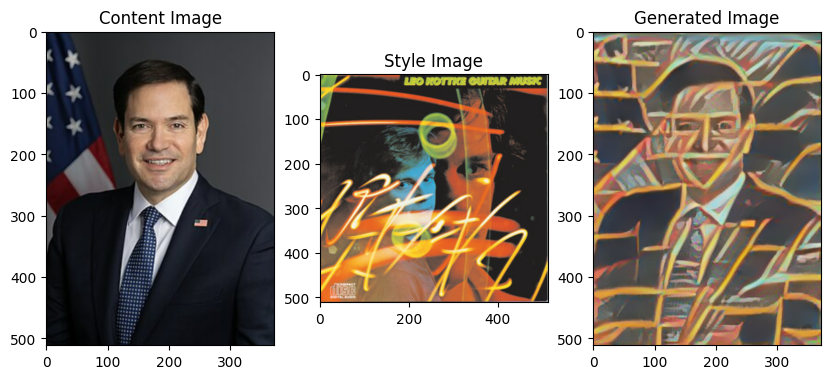

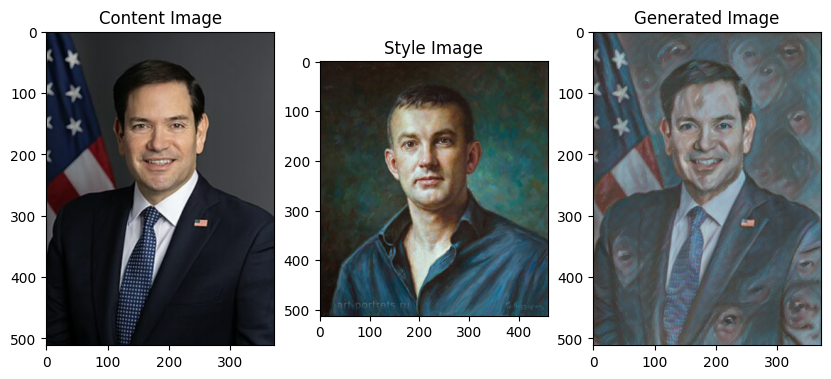

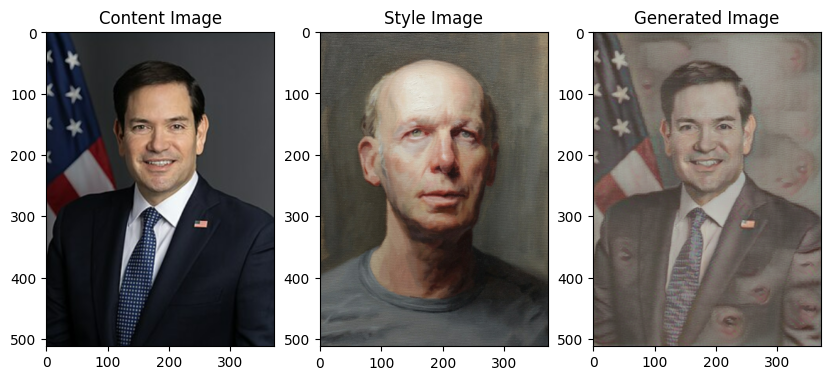

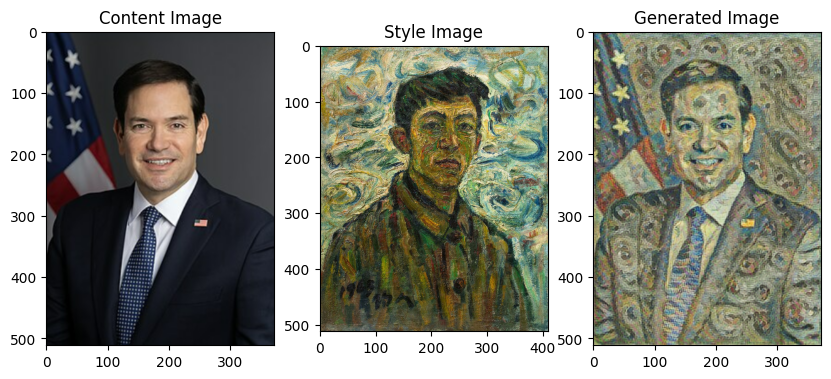

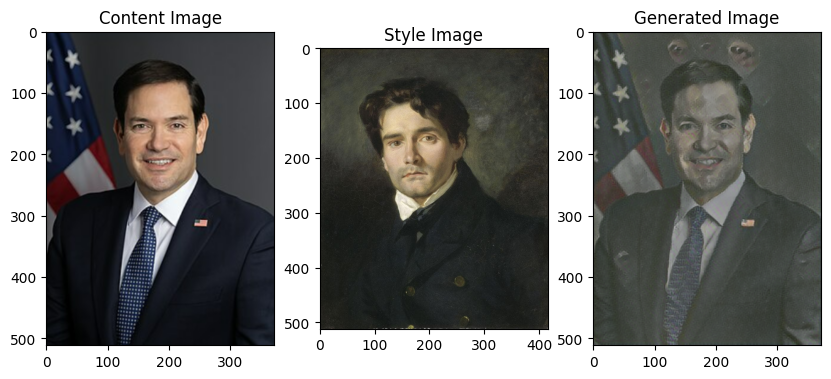

In [67]:
stylize_image("images/Marco_Rubio.jpg", "images/kottke_guitar_music_over.jpg", model1)
stylize_image("images/Marco_Rubio.jpg", "images/portret-molodogo-parnya.jpg", model1)
stylize_image("images/Marco_Rubio.jpg", "images/academic.jpg", model1)
stylize_image("images/Marco_Rubio.jpg", "images/impressionism.jpg", model1)
stylize_image("images/Marco_Rubio.jpg", "images/romanticism.jpg", model1)

#### Image 2

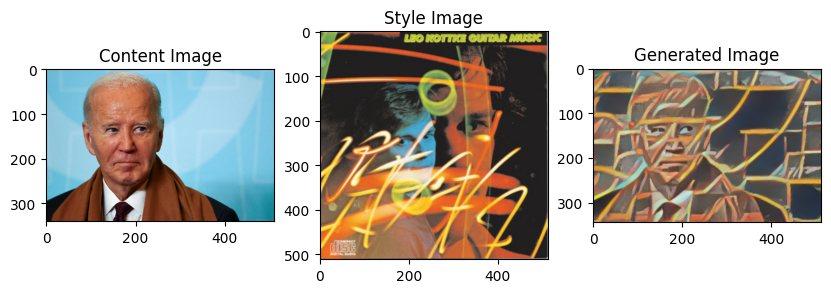

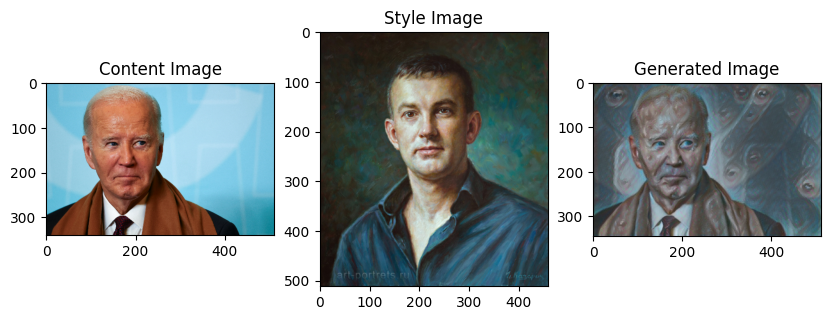

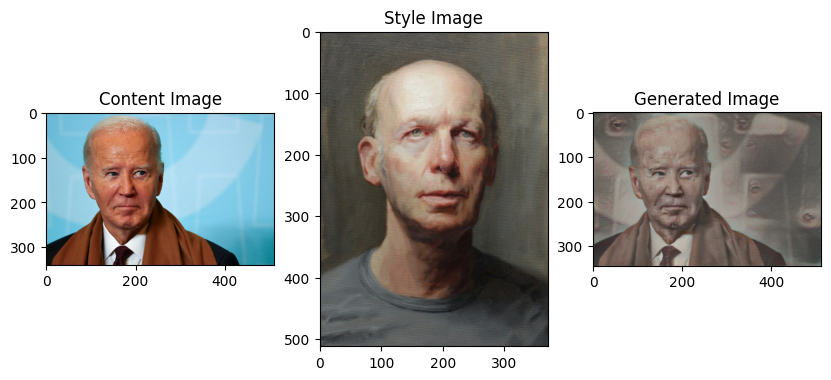

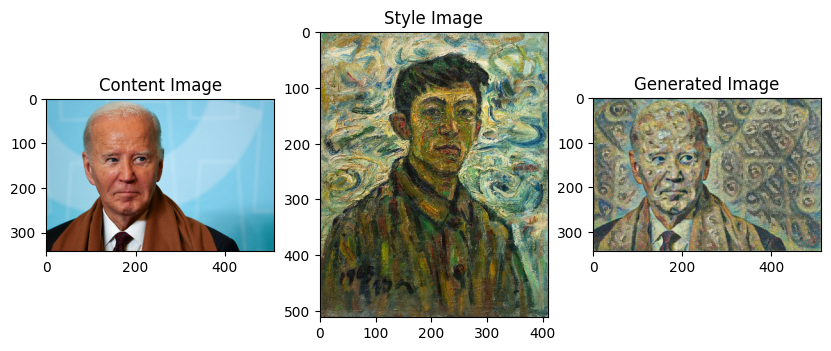

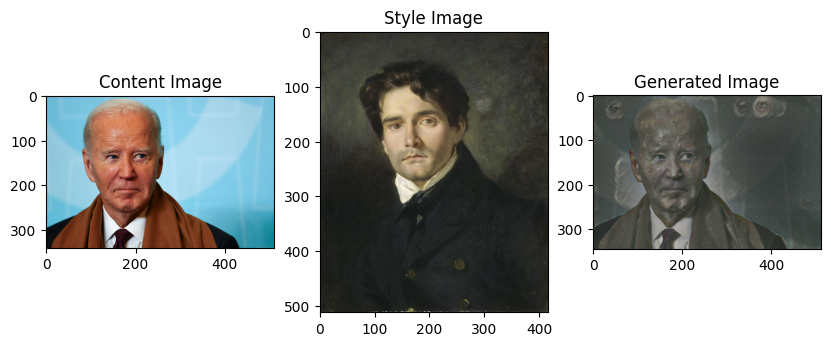

In [68]:
stylize_image("images/joe.jpg", "images/kottke_guitar_music_over.jpg", model1)
stylize_image("images/joe.jpg", "images/portret-molodogo-parnya.jpg", model1)
stylize_image("images/joe.jpg", "images/academic.jpg", model1)
stylize_image("images/joe.jpg", "images/impressionism.jpg", model1)
stylize_image("images/joe.jpg", "images/romanticism.jpg", model1)

The model clearly has a creepy and problematic affinity towards inserting eye-related features everywhere inside the generated photo. Strong response to high-contrast, edge-rich, repeatable patterns in both the content and style images — in other words: eyes - is a common tendency of Convolutional Neural Networks, and there are ways to mitigate it.

Thankfully, state-of-the-art Style Transfer Models do not solely rely on style and content cost differential minimization, but rather on GAN technology (e.g. CycleGan). They're also not weird - or so I hope.

## Custom Model

In [10]:
content_image = load_image("images/Marco_Rubio.jpg")
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('suit', 0.6344928),
 ('Windsor_tie', 0.20651327),
 ('groom', 0.07419214),
 ('notebook', 0.0073928772),
 ('bow_tie', 0.0072322)]

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
def vgg_layers(layer_names):
    """Creates a VGG model that returns a list of intermediate output values."""
    #Load our model, pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [17]:
style_image = load_image("images/academic.jpg")

In [18]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

c:\Users\jom4n\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_70']. Received: the structure of inputs=*
  warnings.warn(


In [19]:
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 512, 371, 64)
  min:  0.0
  max:  761.9329
  mean:  16.446037

block2_conv1
  shape:  (1, 256, 185, 128)
  min:  0.0
  max:  1761.4242
  mean:  83.4861

block3_conv1
  shape:  (1, 128, 92, 256)
  min:  0.0
  max:  3651.2935
  mean:  66.47325

block4_conv1
  shape:  (1, 64, 46, 512)
  min:  0.0
  max:  8419.198
  mean:  312.85052

block5_conv1
  shape:  (1, 32, 23, 512)
  min:  0.0
  max:  2025.5168
  mean:  25.035961



In [20]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result/num_locations

In [22]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [23]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print("Styles:")
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


c:\Users\jom4n\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_92']. Received: the structure of inputs=*
  warnings.warn(


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0017372442
    max:  37132.508
    mean:  444.93927

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  50851.49
    mean:  11090.406

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.5555836
    max:  224062.62
    mean:  10681.186

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3775409.8
    mean:  167735.1

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  219599.39
    mean:  1322.08

Contents:
   block5_conv2
    shape:  (1, 32, 23, 512)
    min:  0.0
    max:  1665.072
    mean:  13.356614


### Gradient Descent

In [25]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

c:\Users\jom4n\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_92']. Received: the structure of inputs=*
  warnings.warn(


In [65]:
image = tf.Variable(content_image)

In [27]:
def clip_values(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Weighted combination of losses:

In [29]:
style_weight = 1e-2
content_weight = 1e4

In [31]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

In [33]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_values(image))

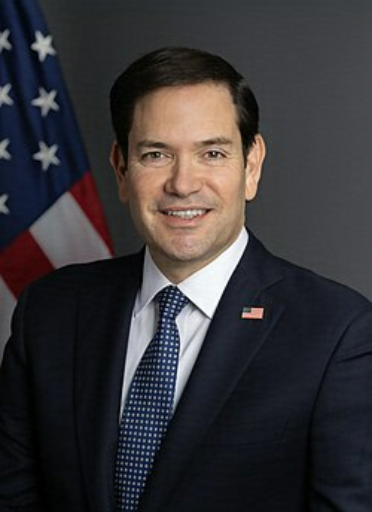

In [66]:
train_step(image)
tensor_to_image(image)

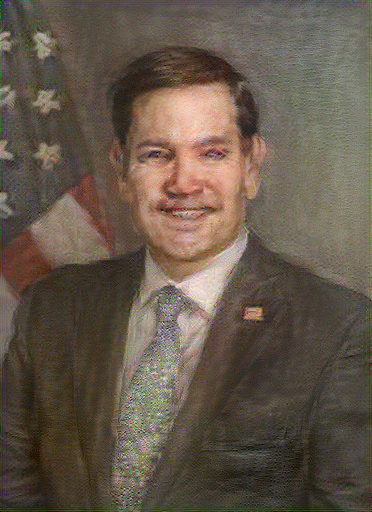

Train step: 1000
Total time: 3486.8


In [75]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    clear_output(wait=True)
    display(tensor_to_image(image))
    print(f"Train step: {step}")

end = time.time()
print(f"Total time: {(end-start):.1f}")

### Regularizing High-frequency Components - Total Variation Loss

A drawback of this basic implementation is the production of high-frequency artifacts - sudden changes in pixel values across the *x* and *y* dimensions - which are practically the same as edges. These differences can be decreased using an explicit regularization term applied to them. This is often called *Total Variation Loss*.  

In [76]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

Text(0.5, 1.0, 'Vertical Deltas: Styled')

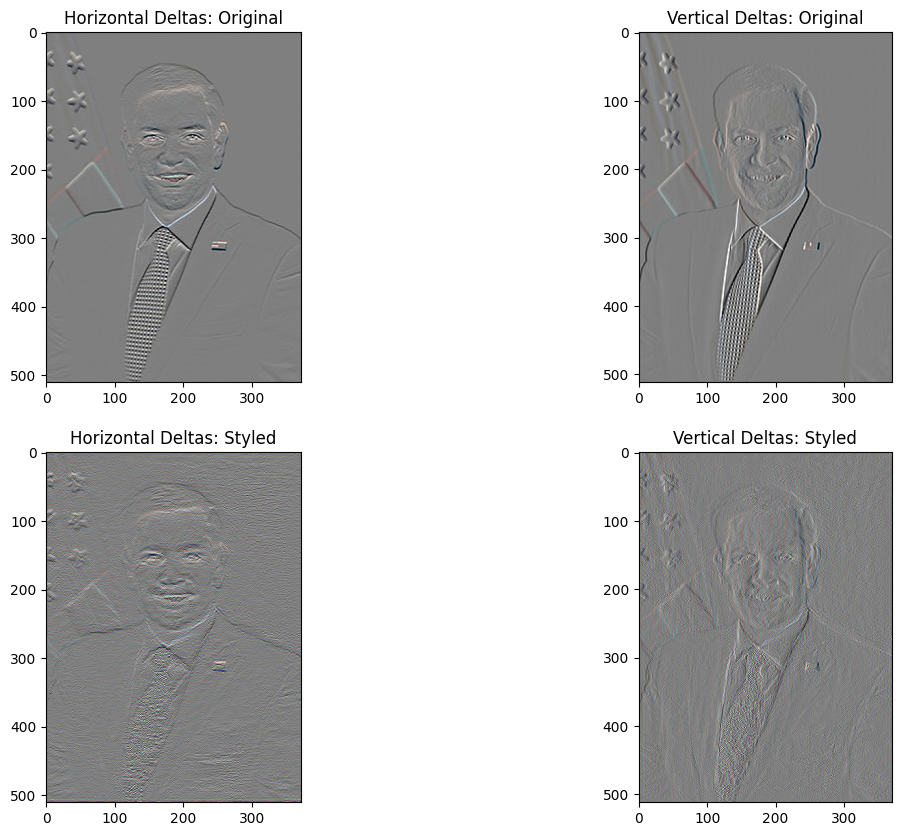

In [77]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.imshow(clip_values(2*y_deltas+0.5)[0, :, :, :])
plt.title("Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
plt.imshow(clip_values(2*x_deltas+0.5)[0, :, :, :])
plt.title("Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
plt.imshow(clip_values(2*y_deltas+0.5)[0, :, :, :])
plt.title("Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
plt.imshow(clip_values(2*x_deltas+0.5)[0, :, :, :])
plt.title("Vertical Deltas: Styled")

Using our custom `total_variation_loss` function:

In [78]:
total_variation_loss(image).numpy()

53907.88

Thankfully, TensorFlow offers a built-in implementation for this correction:

In [79]:
tf.image.total_variation(image).numpy()

array([53907.88], dtype=float32)

### Optimizing using Variation Loss

In [80]:
total_variation_weight = 30

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_values(image))

In [81]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [82]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    clear_output(wait=True)
    display(tensor_to_image(image))
    print(f"Train step: {step}")

end = time.time()
print(f"Total time: {(end-start):.1f}")

c:\Users\jom4n\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_92']. Received: the structure of inputs=*
  warnings.warn(


.

KeyboardInterrupt: 

We interrupt the training and perform it on Google Collab, which results in the following image:

![image](stylized-image.png)

... which is substantially better than the last one when compared to the style image:

![image](images/academic.jpg)

In [ ]:
#Saving stylized image
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
    from google.colab import files
    files.download(file_name)
except (ImportError, AttributeError):
    pass

The question is: can we do better and does it require exponentially more work?